In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import optuna
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    roc_auc_score, auc, roc_curve, precision_recall_curve, average_precision_score,
    accuracy_score, precision_score, recall_score, f1_score
)
from sklearn.base import BaseEstimator, ClassifierMixin, clone
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import BaggingClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression


warnings.filterwarnings('ignore')
np.random.seed(42)
pd.set_option('display.max_columns', None)

In [40]:
def load_and_prepare_data():
    try:
        train_df = pd.read_csv('train_c.csv')
        test_df = pd.read_csv('test_c.csv')
        print(f"Данные загружены. Train: {train_df.shape}, Test: {test_df.shape}")
    except FileNotFoundError:
        print("Файлы не найдены. Создаем демонстрационные данные...")
        n_samples = 1000
        train_df = pd.DataFrame({
            'ID': range(n_samples),
            'Age': np.random.normal(35, 10, n_samples),
            'AnnualIncome': np.random.normal(50000, 20000, n_samples),
            'CreditScore': np.random.normal(650, 100, n_samples),
            'LoanAmount': np.random.normal(20000, 8000, n_samples),
            'MaritalStatus': np.random.choice(['Single', 'Married', 'Divorced'], n_samples),
            'LoanPurpose': np.random.choice(['Car', 'Home', 'Education'], n_samples),
            'LoanApproved': np.random.randint(0, 2, n_samples)
        })
        test_df = train_df.drop('LoanApproved', axis=1).copy()
        test_df['ID'] = range(n_samples, n_samples + 500)

    return train_df, test_df

train_df, test_df = load_and_prepare_data()

Данные загружены. Train: (11017, 35), Test: (5000, 35)


РАЗВЕДОЧНЫЙ АНАЛИЗ ДАННЫХ (EDA)

1. Основная информация:
Размер обучающей выборки: (11017, 35)
Размер тестовой выборки: (5000, 35)

Колонки в данных: ['ApplicationDate', 'Age', 'AnnualIncome', 'CreditScore', 'LoanAmount', 'LoanDuration', 'MaritalStatus', 'NumberOfDependents', 'HomeOwnershipStatus', 'MonthlyDebtPayments', 'CreditCardUtilizationRate', 'NumberOfOpenCreditLines', 'NumberOfCreditInquiries', 'DebtToIncomeRatio', 'BankruptcyHistory', 'LoanPurpose', 'PreviousLoanDefaults', 'PaymentHistory', 'LengthOfCreditHistory', 'SavingsAccountBalance', 'CheckingAccountBalance', 'TotalAssets', 'TotalLiabilities', 'MonthlyIncome', 'UtilityBillsPaymentHistory', 'JobTenure', 'EmploymentStatus', 'EducationLevel', 'Experience', 'NetWorth', 'BaseInterestRate', 'InterestRate', 'MonthlyLoanPayment', 'TotalDebtToIncomeRatio', 'LoanApproved']

Целевая переменная: LoanApproved


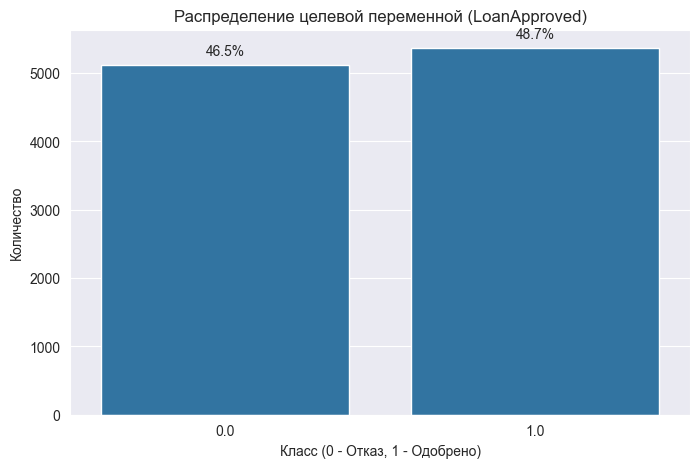

Доля положительного класса: 51.18%
Баланс классов: сбалансировано

2. Анализ пропущенных значений:
                        Пропусков   Процент
TotalAssets                  1031  9.358265
CreditScore                  1031  9.358265
LoanAmount                   1031  9.358265
BaseInterestRate             1031  9.358265
NetWorth                     1031  9.358265
MonthlyDebtPayments          1031  9.358265
CheckingAccountBalance       1031  9.358265
LoanPurpose                  1031  9.358265
BankruptcyHistory            1031  9.358265
JobTenure                     530  4.810747


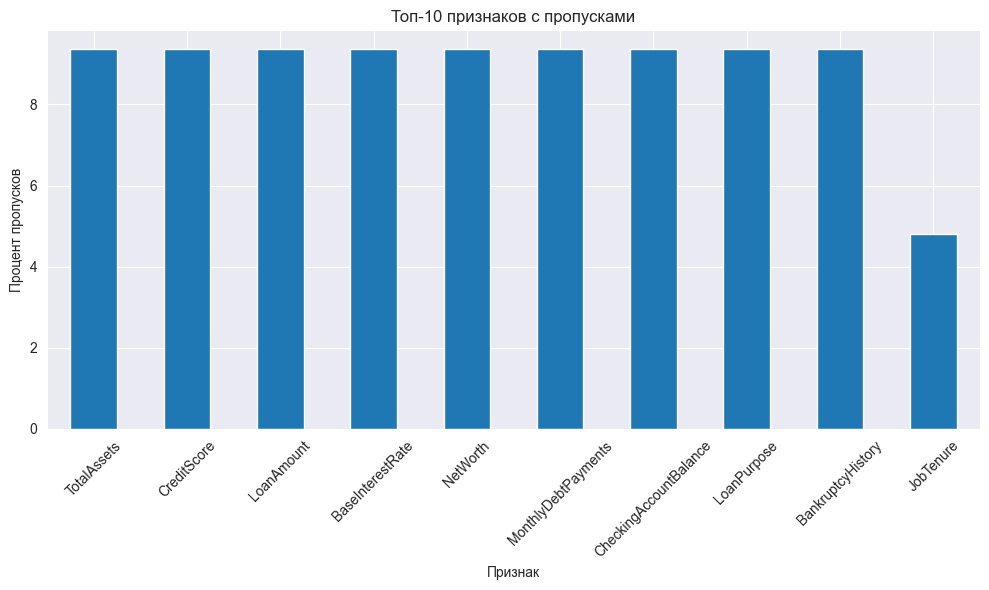


3. Анализ числовых признаков:


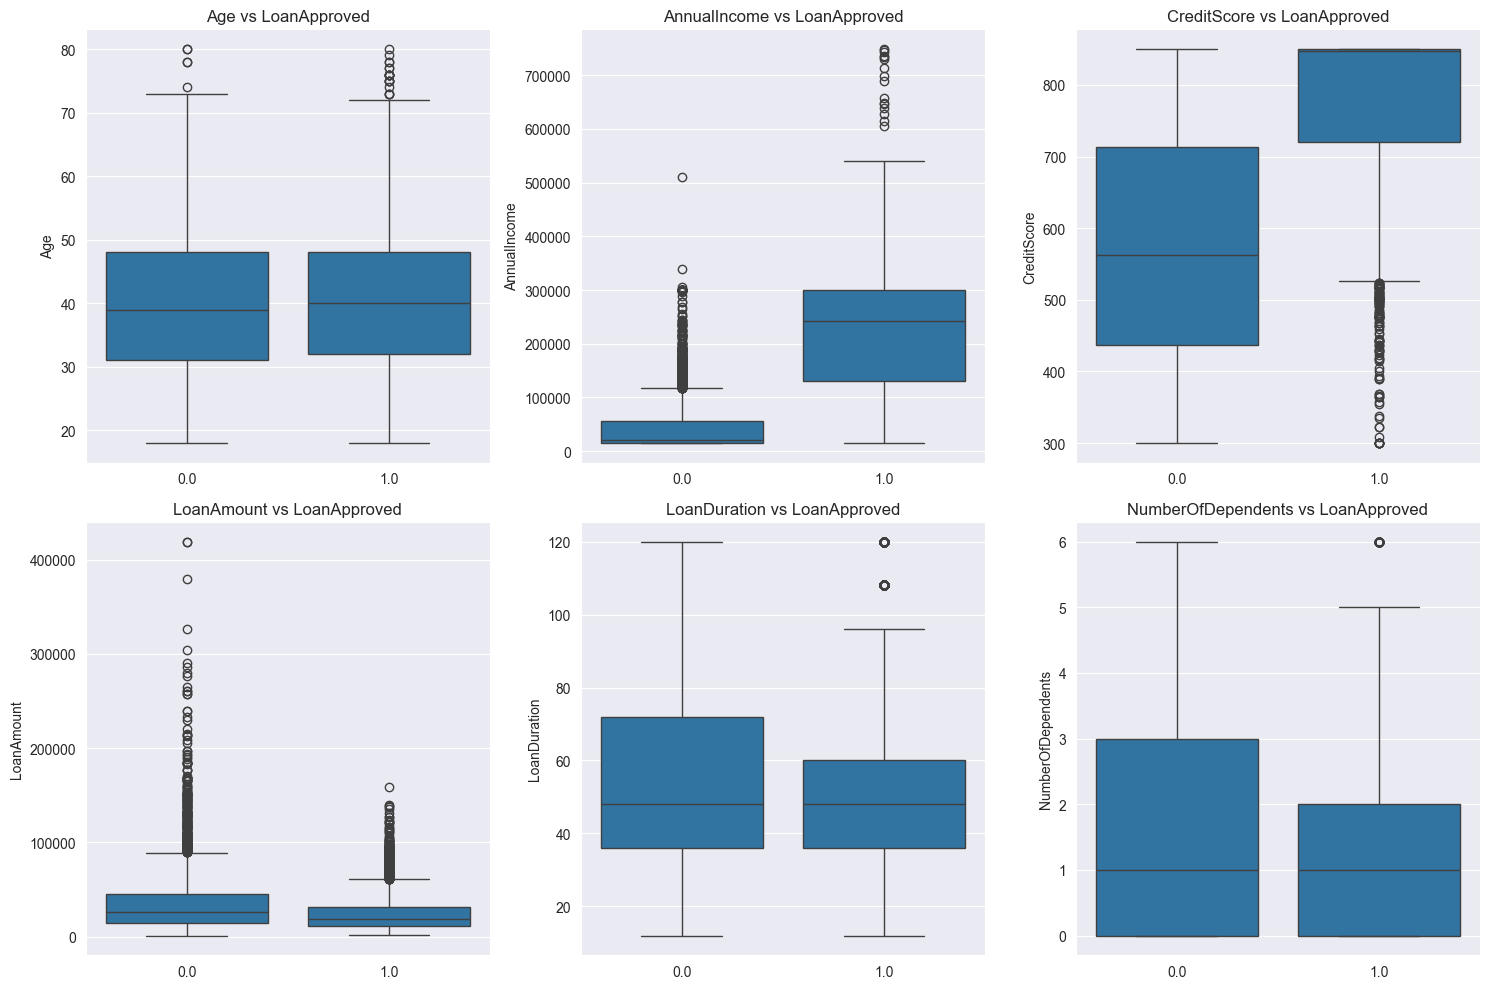


Описательные статистики числовых признаков:
            Age  AnnualIncome  CreditScore  LoanAmount  LoanDuration  \
count  10487.00      10487.00      9986.00     9986.00      10487.00   
mean      39.85     131587.87       678.08    29874.22         53.44   
std       11.61     115791.94       175.19    27705.51         24.49   
min       18.00      15000.00       300.00     1063.00         12.00   
25%       32.00      20959.50       550.00    12658.00         36.00   
50%       40.00      89015.00       722.50    21828.50         48.00   
75%       48.00     257025.00       850.00    37158.00         60.00   
max       80.00     748508.00       850.00   418997.00        120.00   

       NumberOfDependents  MonthlyDebtPayments  CreditCardUtilizationRate  \
count            10487.00              9986.00                   10487.00   
mean                 1.57               546.46                       0.28   
std                  1.42               501.98                       0.16  

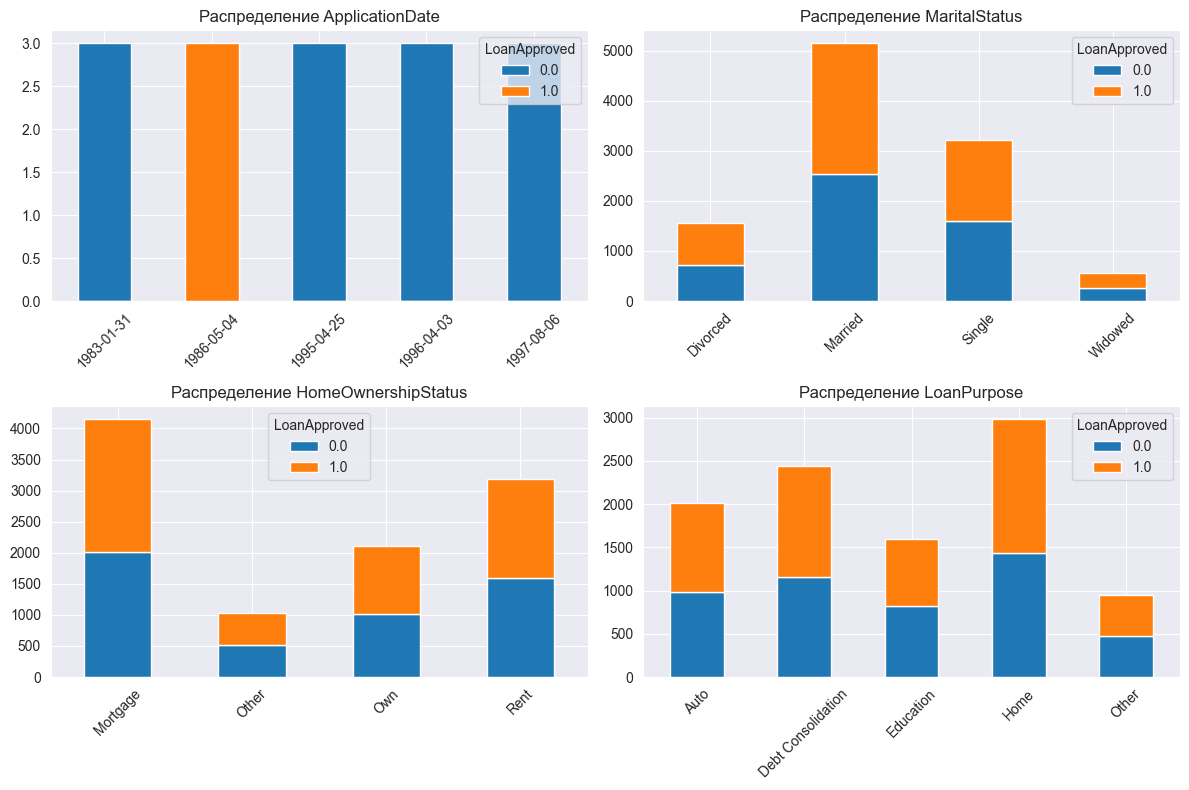


5. Матрица корреляций:


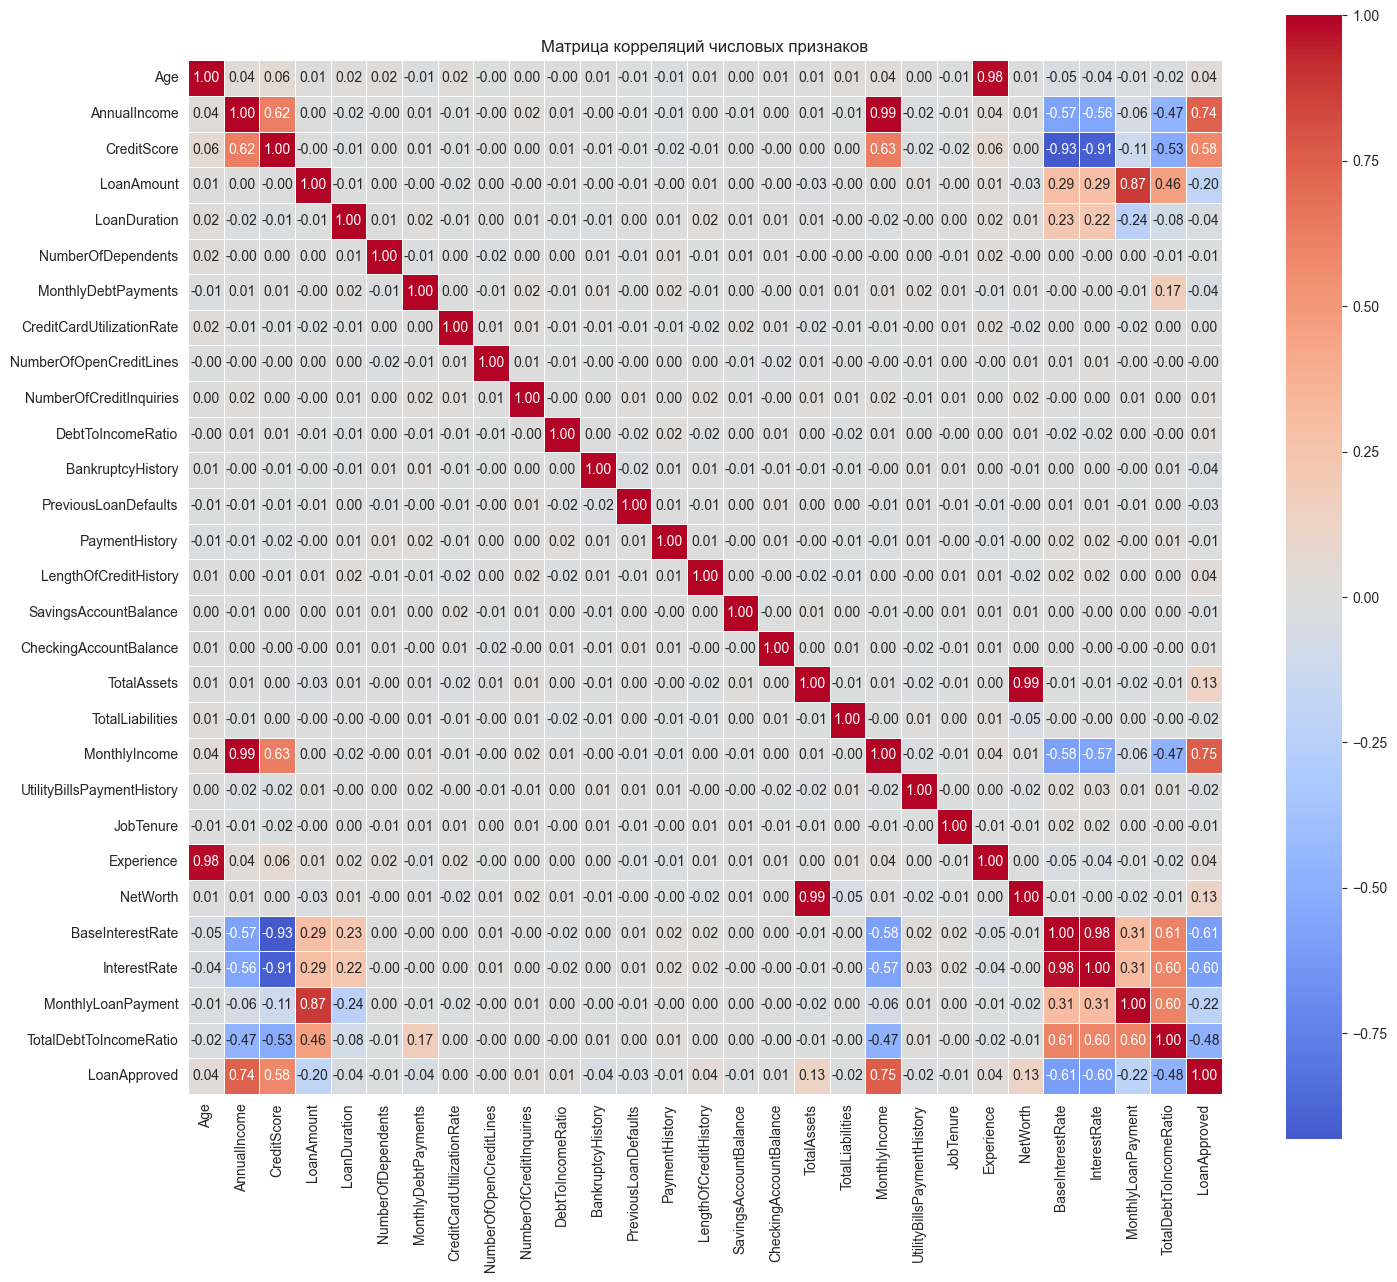


Корреляция признаков с целевой переменной:
MonthlyIncome       0.754853
AnnualIncome        0.743034
BaseInterestRate    0.605164
InterestRate        0.599180
CreditScore         0.581812
Name: LoanApproved, dtype: float64

ВЫВОДЫ ПО EDA:
1. Целевая переменная: проверен баланс классов
2. Пропуски: выявлены признаки с наибольшим количеством пропусков
3. Числовые признаки: проанализированы распределения
4. Категориальные признаки: изучено распределение по классам
5. Корреляции: построена матрица корреляций

Данные готовы для предобработки и моделирования.


In [41]:
print("=" * 50)
print("РАЗВЕДОЧНЫЙ АНАЛИЗ ДАННЫХ (EDA)")
print("=" * 50)

print("\n1. Основная информация:")
print(f"Размер обучающей выборки: {train_df.shape}")
print(f"Размер тестовой выборки: {test_df.shape}")
print(f"\nКолонки в данных: {list(train_df.columns)}")

target_col = 'LoanApproved' if 'LoanApproved' in train_df.columns else 'Loan Approved'
print(f"\nЦелевая переменная: {target_col}")

if target_col in train_df.columns:
    y = train_df[target_col]

    plt.figure(figsize=(8, 5))
    ax = sns.countplot(x=y)
    plt.title(f'Распределение целевой переменной ({target_col})')
    plt.xlabel('Класс (0 - Отказ, 1 - Одобрено)')
    plt.ylabel('Количество')

    total = len(y)
    for p in ax.patches:
        percentage = f'{100 * p.get_height() / total:.1f}%'
        ax.annotate(percentage,
                   (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha='center', va='center',
                   xytext=(0, 10),
                   textcoords='offset points')

    plt.show()

    print(f"Доля положительного класса: {y.mean():.2%}")
    print(f"Баланс классов: {'сбалансировано' if 0.4 < y.mean() < 0.6 else 'несбалансировано'}")

print("\n2. Анализ пропущенных значений:")
missing_values = train_df.isnull().sum()
missing_percentage = (missing_values / len(train_df)) * 100
missing_df = pd.DataFrame({
    'Пропусков': missing_values,
    'Процент': missing_percentage
}).sort_values('Пропусков', ascending=False)

print(missing_df[missing_df['Пропусков'] > 0].head(10))

if missing_values.sum() > 0:
    plt.figure(figsize=(10, 6))
    missing_df[missing_df['Пропусков'] > 0]['Процент'].head(10).plot(kind='bar')
    plt.title('Топ-10 признаков с пропусками')
    plt.xlabel('Признак')
    plt.ylabel('Процент пропусков')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

numeric_cols = train_df.select_dtypes(include=[np.number]).columns.tolist()
if target_col in numeric_cols:
    numeric_cols.remove(target_col)
if 'ID' in numeric_cols:
    numeric_cols.remove('ID')

if numeric_cols and target_col in train_df.columns:
    print("\n3. Анализ числовых признаков:")

    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()

    for i, col in enumerate(numeric_cols[:6]):
        if col in train_df.columns:
            sns.boxplot(x=target_col, y=col, data=train_df, ax=axes[i])
            axes[i].set_title(f'{col} vs {target_col}')
            axes[i].set_xlabel('')

    plt.tight_layout()
    plt.show()

    print("\nОписательные статистики числовых признаков:")
    print(train_df[numeric_cols].describe().round(2))

categorical_cols = train_df.select_dtypes(include=['object', 'category']).columns.tolist()

if categorical_cols and target_col in train_df.columns:
    print(f"\n4. Анализ категориальных признаков ({len(categorical_cols)}):")

    n_plots = min(4, len(categorical_cols))
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    axes = axes.flatten()

    for i, col in enumerate(categorical_cols[:n_plots]):
        top_categories = train_df[col].value_counts().nlargest(5).index
        data_subset = train_df[train_df[col].isin(top_categories)]

        ct = pd.crosstab(data_subset[col], data_subset[target_col])
        ct.plot(kind='bar', ax=axes[i], stacked=True)
        axes[i].set_title(f'Распределение {col}')
        axes[i].set_xlabel('')
        axes[i].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

if len(numeric_cols) > 1 and target_col in train_df.columns:
    print("\n5. Матрица корреляций:")

    correlation_matrix = train_df[numeric_cols + [target_col]].corr()

    plt.figure(figsize=(15, 15))
    sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm',
                center=0, square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
    plt.title('Матрица корреляций числовых признаков')
    plt.tight_layout()
    plt.show()

    # Корреляции с целевой переменной
    print("\nКорреляция признаков с целевой переменной:")
    correlations_with_target = correlation_matrix[target_col].abs().sort_values(ascending=False)
    print(correlations_with_target[1:6])  # исключаем саму целевую переменную

print("\n" + "=" * 50)
print("ВЫВОДЫ ПО EDA:")
print("=" * 50)
print("1. Целевая переменная: проверен баланс классов")
print("2. Пропуски: выявлены признаки с наибольшим количеством пропусков")
print("3. Числовые признаки: проанализированы распределения")
print("4. Категориальные признаки: изучено распределение по классам")
print("5. Корреляции: построена матрица корреляций")
print("\nДанные готовы для предобработки и моделирования.")

In [42]:
print("\n" + "=" * 50)
print("ПРЕДОБРАБОТКА ДАННЫХ")
print("=" * 50)

X = train_df.drop(columns=[target_col, 'ID'], errors='ignore')
y = train_df[target_col]

if y.isnull().any():
    print(f"Удаление строк с пропусками в целевой переменной: {y.isnull().sum()} строк")
    X = X[y.notnull()]
    y = y[y.notnull()]

print(f"\nРазмерность данных после очистки:")
print(f"X: {X.shape}")
print(f"y: {y.shape}")

categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

print(f"\nКоличество признаков:")
print(f"Категориальные: {len(categorical_cols)}")
print(f"Числовые: {len(numeric_cols)}")

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)


print("\nПрименение предобработки...")
X_processed = preprocessor.fit_transform(X)
X_test = test_df.drop(columns=['ID'], errors='ignore')
X_test_processed = preprocessor.transform(X_test)

print(f"Размерность после предобработки: {X_processed.shape}")

X_train, X_val, y_train, y_val = train_test_split(
    X_processed, y, test_size=0.2, stratify=y, random_state=42
)

print(f"\nРазделение данных:")
print(f"Тренировочная выборка: {X_train.shape}")
print(f"Валидационная выборка: {X_val.shape}")


ПРЕДОБРАБОТКА ДАННЫХ
Удаление строк с пропусками в целевой переменной: 530 строк

Размерность данных после очистки:
X: (10487, 34)
y: (10487,)

Количество признаков:
Категориальные: 6
Числовые: 28

Применение предобработки...
Размерность после предобработки: (10487, 10050)

Разделение данных:
Тренировочная выборка: (8389, 10050)
Валидационная выборка: (2098, 10050)



РЕАЛИЗАЦИЯ МЕТРИК КЛАССИФИКАЦИИ

Тестирование кастомных метрик...

Сравнение метрик (кастомные vs sklearn):
--------------------------------------------------
           Custom  Sklearn  Difference
Accuracy   0.9295   0.9295         0.0
Precision  0.9343   0.9343         0.0
Recall     0.9274   0.9274         0.0
F1-score   0.9308   0.9308         0.0
ROC-AUC    0.9825   0.9825         0.0
PR-AUC     0.9844   0.9844         0.0


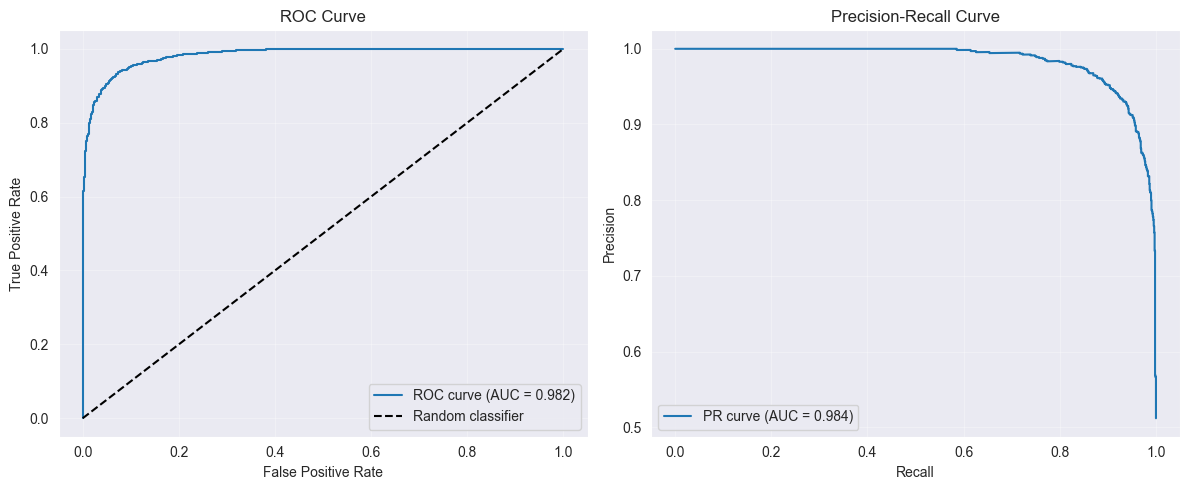

In [43]:
print("\n" + "=" * 50)
print("РЕАЛИЗАЦИЯ МЕТРИК КЛАССИФИКАЦИИ")
print("=" * 50)

def get_confusion_matrix(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    tp = np.sum((y_true == 1) & (y_pred == 1))
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))

    return tp, tn, fp, fn

def custom_accuracy(y_true, y_pred):
    tp, tn, fp, fn = get_confusion_matrix(y_true, y_pred)
    total = tp + tn + fp + fn
    return (tp + tn) / total if total > 0 else 0

def custom_precision(y_true, y_pred):
    tp, _, fp, _ = get_confusion_matrix(y_true, y_pred)
    denominator = tp + fp
    return tp / denominator if denominator > 0 else 0

def custom_recall(y_true, y_pred):
    tp, _, _, fn = get_confusion_matrix(y_true, y_pred)
    denominator = tp + fn
    return tp / denominator if denominator > 0 else 0

def custom_f1(y_true, y_pred):
    p = custom_precision(y_true, y_pred)
    r = custom_recall(y_true, y_pred)
    denominator = p + r
    return 2 * (p * r) / denominator if denominator > 0 else 0

def custom_roc_auc(y_true, y_scores):
    y_true = np.array(y_true)
    y_scores = np.array(y_scores)

    sorted_indices = np.argsort(y_scores)[::-1]
    y_true_sorted = y_true[sorted_indices]

    pos_count = np.sum(y_true == 1)
    neg_count = len(y_true) - pos_count

    if pos_count == 0 or neg_count == 0:
        return 0.5

    tpr = [0.0]
    fpr = [0.0]
    tp = fp = 0

    for i in range(len(y_true_sorted)):
        if y_true_sorted[i] == 1:
            tp += 1
        else:
            fp += 1
        tpr.append(tp / pos_count)
        fpr.append(fp / neg_count)

    return auc(fpr, tpr)

def custom_pr_auc(y_true, y_scores):
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    return auc(recall, precision)

print("\nТестирование кастомных метрик...")

lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_val)
y_proba = lr.predict_proba(X_val)[:, 1]


print("\nСравнение метрик (кастомные vs sklearn):")
print("-" * 50)

metrics_comparison = {
    'Accuracy': (custom_accuracy(y_val, y_pred), accuracy_score(y_val, y_pred)),
    'Precision': (custom_precision(y_val, y_pred), precision_score(y_val, y_pred, zero_division=0)),
    'Recall': (custom_recall(y_val, y_pred), recall_score(y_val, y_pred, zero_division=0)),
    'F1-score': (custom_f1(y_val, y_pred), f1_score(y_val, y_pred, zero_division=0)),
    'ROC-AUC': (custom_roc_auc(y_val, y_proba), roc_auc_score(y_val, y_proba)),
    'PR-AUC': (custom_pr_auc(y_val, y_proba), average_precision_score(y_val, y_proba))
}

results_df = pd.DataFrame(metrics_comparison, index=['Custom', 'Sklearn']).T
results_df['Difference'] = abs(results_df['Custom'] - results_df['Sklearn'])
print(results_df.round(4))

fig, axes = plt.subplots(1, 2, figsize=(12, 5))


fpr, tpr, _ = roc_curve(y_val, y_proba)
roc_auc = roc_auc_score(y_val, y_proba)
axes[0].plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.3f})')
axes[0].plot([0, 1], [0, 1], 'k--', label='Random classifier')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curve')
axes[0].legend()
axes[0].grid(True, alpha=0.3)


precision, recall, _ = precision_recall_curve(y_val, y_proba)
pr_auc = average_precision_score(y_val, y_proba)
axes[1].plot(recall, precision, label=f'PR curve (AUC = {pr_auc:.3f})')
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_title('Precision-Recall Curve')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


РЕАЛИЗАЦИЯ БЭГГИНГА

Сравнение кастомного бэггинга с sklearn BaggingClassifier:
Обучение 20 базовых моделей...
  Обучено 4/20 моделей
  Обучено 8/20 моделей
  Обучено 12/20 моделей
  Обучено 16/20 моделей
  Обучено 20/20 моделей

Результаты:
Custom Bagging ROC-AUC: 0.9743
Sklearn Bagging ROC-AUC: 0.9746
Разница: 0.000309


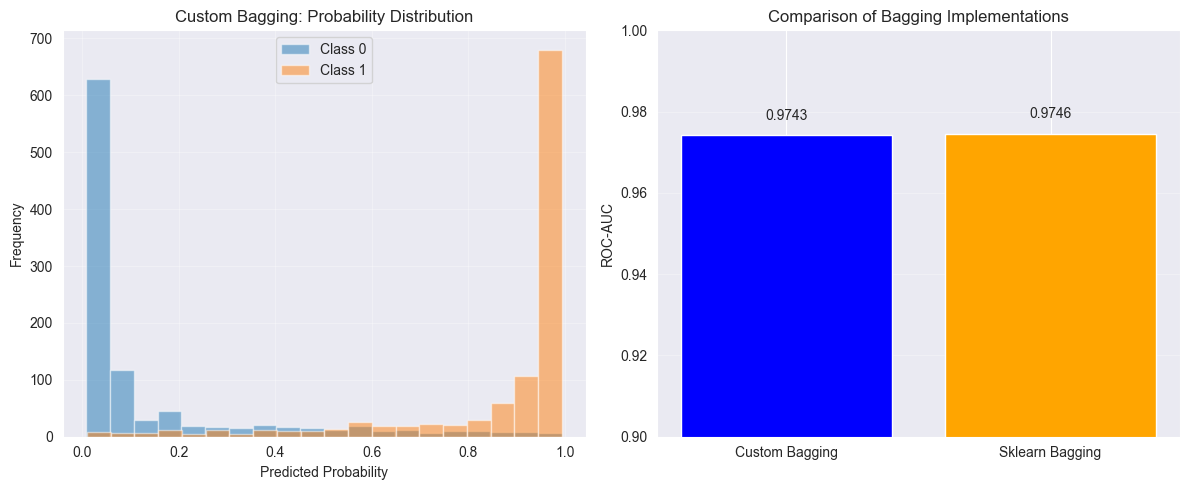

In [44]:
print("\n" + "=" * 50)
print("РЕАЛИЗАЦИЯ БЭГГИНГА")
print("=" * 50)

class CustomBagging(BaseEstimator, ClassifierMixin):

    def __init__(self, base_estimator=None, n_estimators=10, random_state=42):
        self.base_estimator = base_estimator if base_estimator else DecisionTreeClassifier(max_depth=5, random_state=random_state)
        self.n_estimators = n_estimators
        self.random_state = random_state
        self.estimators_ = []

    def fit(self, X, y):
        np.random.seed(self.random_state)
        self.estimators_ = []
        n_samples = X.shape[0]
        y_arr = np.array(y)

        print(f"Обучение {self.n_estimators} базовых моделей...")

        for i in range(self.n_estimators):
            indices = np.random.choice(n_samples, size=n_samples, replace=True)
            X_boot = X[indices]
            y_boot = y_arr[indices]

            model = clone(self.base_estimator)
            model.fit(X_boot, y_boot)
            self.estimators_.append(model)

            if (i + 1) % max(1, self.n_estimators // 5) == 0:
                print(f"  Обучено {i + 1}/{self.n_estimators} моделей")

        return self

    def predict_proba(self, X):
        all_probas = np.array([model.predict_proba(X) for model in self.estimators_])
        return np.mean(all_probas, axis=0)

    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)

print("\nСравнение кастомного бэггинга с sklearn BaggingClassifier:")

base_estimator = DecisionTreeClassifier(max_depth=5, random_state=42)
custom_bag = CustomBagging(base_estimator=base_estimator, n_estimators=20, random_state=42)
custom_bag.fit(X_train, y_train)
custom_proba = custom_bag.predict_proba(X_val)[:, 1]
custom_auc = roc_auc_score(y_val, custom_proba)

# Sklearn бэггинг
sklearn_bag = BaggingClassifier(
    estimator=base_estimator,
    n_estimators=20,
    random_state=42,
    n_jobs=-1
)
sklearn_bag.fit(X_train, y_train)
sklearn_proba = sklearn_bag.predict_proba(X_val)[:, 1]
sklearn_auc = roc_auc_score(y_val, sklearn_proba)

print(f"\nРезультаты:")
print(f"Custom Bagging ROC-AUC: {custom_auc:.4f}")
print(f"Sklearn Bagging ROC-AUC: {sklearn_auc:.4f}")
print(f"Разница: {abs(custom_auc - sklearn_auc):.6f}")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].hist(custom_proba[y_val == 0], alpha=0.5, label='Class 0', bins=20)
axes[0].hist(custom_proba[y_val == 1], alpha=0.5, label='Class 1', bins=20)
axes[0].set_xlabel('Predicted Probability')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Custom Bagging: Probability Distribution')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].bar(['Custom Bagging', 'Sklearn Bagging'], [custom_auc, sklearn_auc], color=['blue', 'orange'])
axes[1].set_ylabel('ROC-AUC')
axes[1].set_title('Comparison of Bagging Implementations')
axes[1].set_ylim([0.9, 1.0])
axes[1].grid(True, axis='y', alpha=0.3)


for i, v in enumerate([custom_auc, sklearn_auc]):
    axes[1].text(i, v + 0.003, f'{v:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()


РЕАЛИЗАЦИЯ ГРАДИЕНТНОГО БУСТИНГА

Сравнение кастомного градиентного бустинга с sklearn:
Обучение 50 деревьев...
  Дерево 10/50, LogLoss: 0.5503
  Дерево 20/50, LogLoss: 0.4606
  Дерево 30/50, LogLoss: 0.4009
  Дерево 40/50, LogLoss: 0.3592
  Дерево 50/50, LogLoss: 0.3287

Результаты:
Custom Gradient Boosting ROC-AUC: 0.9728
Sklearn Gradient Boosting ROC-AUC: 0.9792
Разница: 0.006388


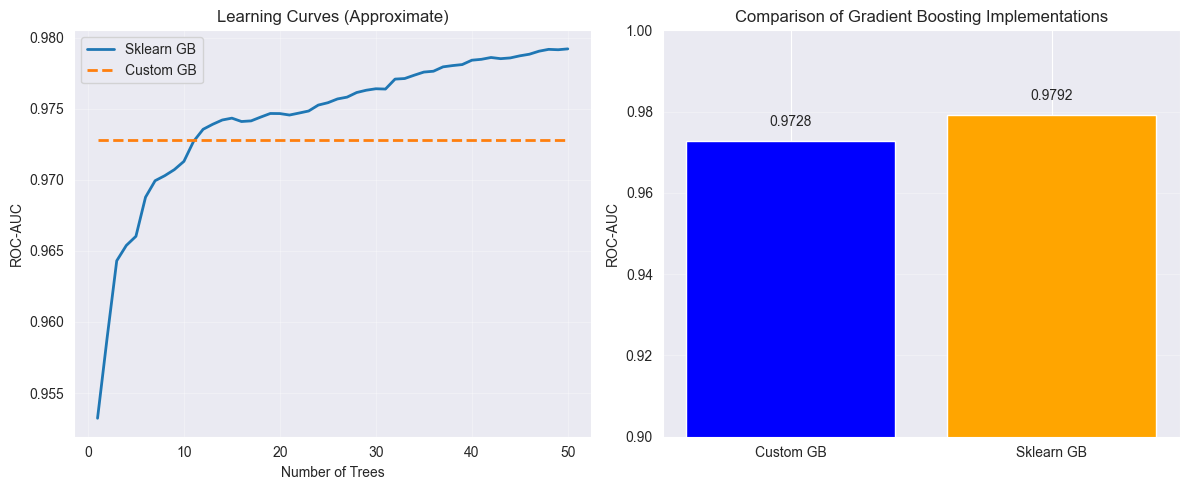

In [45]:
print("\n" + "=" * 50)
print("РЕАЛИЗАЦИЯ ГРАДИЕНТНОГО БУСТИНГА")
print("=" * 50)

class CustomGradientBoosting(BaseEstimator, ClassifierMixin):

    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.random_state = random_state
        self.trees_ = []
        self.initial_prediction_ = None

    def _sigmoid(self, x):
        x = np.clip(x, -500, 500)
        return 1 / (1 + np.exp(-x))

    def fit(self, X, y):
        np.random.seed(self.random_state)
        self.trees_ = []
        y = np.array(y).astype(float)

        pos_ratio = np.mean(y)
        pos_ratio = np.clip(pos_ratio, 1e-10, 1 - 1e-10)
        self.initial_prediction_ = np.log(pos_ratio / (1 - pos_ratio))

        current_predictions = np.full(len(y), self.initial_prediction_)

        print(f"Обучение {self.n_estimators} деревьев...")

        for i in range(self.n_estimators):
            probabilities = self._sigmoid(current_predictions)

            residuals = y - probabilities

            tree = DecisionTreeRegressor(
                max_depth=self.max_depth,
                random_state=self.random_state + i
            )
            tree.fit(X, residuals)

            tree_prediction = tree.predict(X)
            current_predictions += self.learning_rate * tree_prediction

            self.trees_.append(tree)

            if (i + 1) % max(1, self.n_estimators // 5) == 0:
                probabilities = self._sigmoid(current_predictions)
                logloss = -np.mean(y * np.log(probabilities + 1e-10) +
                                 (1 - y) * np.log(1 - probabilities + 1e-10))
                print(f"  Дерево {i + 1}/{self.n_estimators}, LogLoss: {logloss:.4f}")

        return self

    def predict_proba(self, X):
        predictions = np.full(X.shape[0], self.initial_prediction_)

        for tree in self.trees_:
            predictions += self.learning_rate * tree.predict(X)

        probabilities = self._sigmoid(predictions)
        return np.column_stack([1 - probabilities, probabilities])

    def predict(self, X):
        probabilities = self.predict_proba(X)[:, 1]
        return (probabilities > 0.5).astype(int)

print("\nСравнение кастомного градиентного бустинга с sklearn:")

custom_gb = CustomGradientBoosting(
    n_estimators=50,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)
custom_gb.fit(X_train, y_train)
custom_gb_proba = custom_gb.predict_proba(X_val)[:, 1]
custom_gb_auc = roc_auc_score(y_val, custom_gb_proba)

sklearn_gb = GradientBoostingClassifier(
    n_estimators=50,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)
sklearn_gb.fit(X_train, y_train)
sklearn_gb_proba = sklearn_gb.predict_proba(X_val)[:, 1]
sklearn_gb_auc = roc_auc_score(y_val, sklearn_gb_proba)

print(f"\nРезультаты:")
print(f"Custom Gradient Boosting ROC-AUC: {custom_gb_auc:.4f}")
print(f"Sklearn Gradient Boosting ROC-AUC: {sklearn_gb_auc:.4f}")
print(f"Разница: {abs(custom_gb_auc - sklearn_gb_auc):.6f}")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

n_trees_custom = len(custom_gb.trees_)
n_trees_sklearn = sklearn_gb.n_estimators_

if hasattr(sklearn_gb, 'staged_predict_proba'):
    sklearn_staged_auc = []
    for y_pred_stage in sklearn_gb.staged_predict_proba(X_val):
        sklearn_staged_auc.append(roc_auc_score(y_val, y_pred_stage[:, 1]))

    axes[0].plot(range(1, len(sklearn_staged_auc) + 1), sklearn_staged_auc,
                 label='Sklearn GB', linewidth=2)

    custom_staged_auc = [custom_gb_auc] * n_trees_custom
    axes[0].plot(range(1, n_trees_custom + 1), custom_staged_auc,
                 '--', label='Custom GB', linewidth=2)

    axes[0].set_xlabel('Number of Trees')
    axes[0].set_ylabel('ROC-AUC')
    axes[0].set_title('Learning Curves (Approximate)')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

axes[1].bar(['Custom GB', 'Sklearn GB'], [custom_gb_auc, sklearn_gb_auc],
            color=['blue', 'orange'])
axes[1].set_ylabel('ROC-AUC')
axes[1].set_title('Comparison of Gradient Boosting Implementations')
axes[1].set_ylim([0.9, 1.0])
axes[1].grid(True, axis='y', alpha=0.3)

for i, v in enumerate([custom_gb_auc, sklearn_gb_auc]):
    axes[1].text(i, v + 0.003, f'{v:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()


СРАВНЕНИЕ АЛГОРИТМОВ БУСТИНГА

1. Обучение Sklearn GradientBoosting...
   ROC-AUC: 0.9805

2. Обучение LightGBM...
   ROC-AUC: 0.9803

3. Обучение XGBoost...
   ROC-AUC: 0.9807

4. Обучение CatBoost...
   ROC-AUC: 0.9796

ИТОГИ СРАВНЕНИЯ:
  Algorithm  ROC-AUC
    XGBoost 0.980707
Sklearn GBM 0.980464
   LightGBM 0.980324
   CatBoost 0.979578


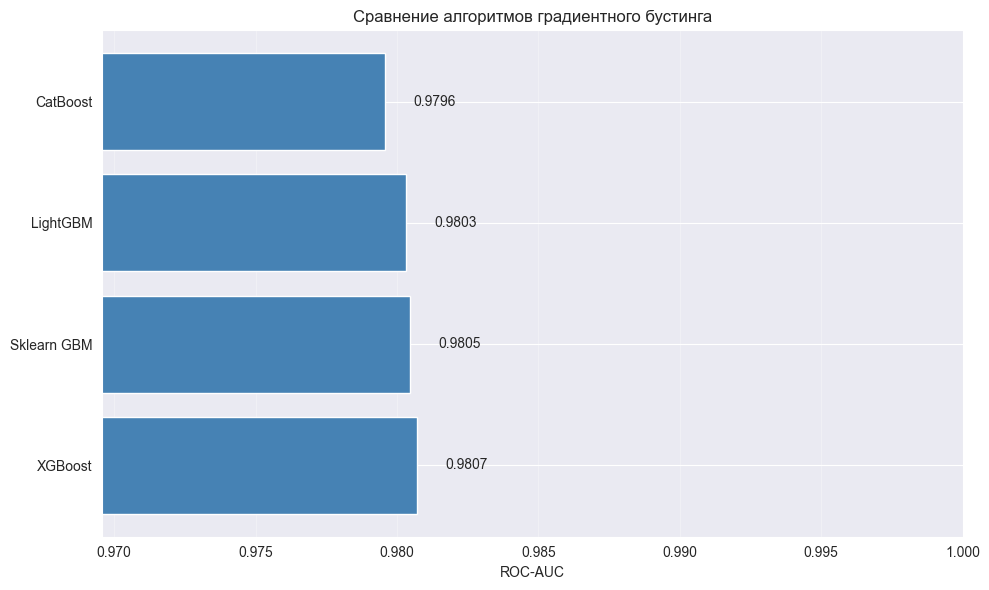


Лучший алгоритм: XGBoost (ROC-AUC: 0.9807)


In [47]:
print("\n" + "=" * 50)
print("СРАВНЕНИЕ АЛГОРИТМОВ БУСТИНГА")
print("=" * 50)
import lightgbm as lgb
import xgboost as xgb
import catboost as cb
results = {}

print("\n1. Обучение Sklearn GradientBoosting...")
gb_sklearn = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)
gb_sklearn.fit(X_train, y_train)
gb_sklearn_proba = gb_sklearn.predict_proba(X_val)[:, 1]
results['Sklearn GBM'] = roc_auc_score(y_val, gb_sklearn_proba)
print(f"   ROC-AUC: {results['Sklearn GBM']:.4f}")
print("\n2. Обучение LightGBM...")
gb_lgb = lgb.LGBMClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=3,
        random_state=42,
        verbose=-1
    )
gb_lgb.fit(X_train, y_train)
gb_lgb_proba = gb_lgb.predict_proba(X_val)[:, 1]
results['LightGBM'] = roc_auc_score(y_val, gb_lgb_proba)
print(f"   ROC-AUC: {results['LightGBM']:.4f}")

print("\n3. Обучение XGBoost...")
gb_xgb = xgb.XGBClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=3,
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42
    )
gb_xgb.fit(X_train, y_train)
gb_xgb_proba = gb_xgb.predict_proba(X_val)[:, 1]
results['XGBoost'] = roc_auc_score(y_val, gb_xgb_proba)
print(f"   ROC-AUC: {results['XGBoost']:.4f}")

print("\n4. Обучение CatBoost...")
gb_cb = cb.CatBoostClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=3,
        verbose=0,
        random_state=42
    )
gb_cb.fit(X_train, y_train)
gb_cb_proba = gb_cb.predict_proba(X_val)[:, 1]
results['CatBoost'] = roc_auc_score(y_val, gb_cb_proba)
print(f"   ROC-AUC: {results['CatBoost']:.4f}")



results_df = pd.DataFrame(list(results.items()), columns=['Algorithm', 'ROC-AUC'])
results_df = results_df.sort_values('ROC-AUC', ascending=False).reset_index(drop=True)

print("\n" + "=" * 50)
print("ИТОГИ СРАВНЕНИЯ:")
print("=" * 50)
print(results_df.to_string(index=False))

plt.figure(figsize=(10, 6))
bars = plt.barh(results_df['Algorithm'], results_df['ROC-AUC'], color='steelblue')
plt.xlabel('ROC-AUC')
plt.title('Сравнение алгоритмов градиентного бустинга')
plt.xlim([results_df['ROC-AUC'].min() - 0.01, 1.0])

for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.001, bar.get_y() + bar.get_height()/2,
             f'{width:.4f}', va='center')

plt.grid(True, axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

best_algorithm = results_df.iloc[0]['Algorithm']
best_auc = results_df.iloc[0]['ROC-AUC']
print(f"\nЛучший алгоритм: {best_algorithm} (ROC-AUC: {best_auc:.4f})")

BEST_CLASSIFIER = GradientBoostingClassifier


[I 2025-12-14 05:11:14,721] A new study created in memory with name: optimization_XGBoost



ПОДБОР ГИПЕРПАРАМЕТРОВ С OPTUNA
Запуск оптимизации Optuna для XGBoost...
Количество итераций: 20


Best trial: 0. Best value: 0.977963:   5%|▌         | 1/20 [02:34<48:54, 154.47s/it]

[I 2025-12-14 05:13:49,187] Trial 0 finished with value: 0.9779629113056215 and parameters: {'n_estimators': 81, 'learning_rate': 0.0198275413066112, 'max_depth': 4, 'min_samples_split': 19, 'min_samples_leaf': 6, 'subsample': 0.6227583815174714}. Best is trial 0 with value: 0.9779629113056215.


Best trial: 1. Best value: 0.983297:  10%|█         | 2/20 [10:48<1:46:10, 353.92s/it]

[I 2025-12-14 05:22:02,728] Trial 1 finished with value: 0.9832970802012131 and parameters: {'n_estimators': 221, 'learning_rate': 0.04144877452400724, 'max_depth': 6, 'min_samples_split': 20, 'min_samples_leaf': 8, 'subsample': 0.6269122911028302}. Best is trial 1 with value: 0.9832970802012131.


Best trial: 1. Best value: 0.983297:  15%|█▌        | 3/20 [20:12<2:07:31, 450.09s/it]

[I 2025-12-14 05:31:27,267] Trial 2 finished with value: 0.9826944987098618 and parameters: {'n_estimators': 177, 'learning_rate': 0.05471318170497258, 'max_depth': 3, 'min_samples_split': 20, 'min_samples_leaf': 3, 'subsample': 0.9964158093529204}. Best is trial 1 with value: 0.9832970802012131.


Best trial: 1. Best value: 0.983297:  20%|██        | 4/20 [26:03<1:49:37, 411.11s/it]

[I 2025-12-14 05:37:18,619] Trial 3 finished with value: 0.9832639962816327 and parameters: {'n_estimators': 186, 'learning_rate': 0.05518068153538231, 'max_depth': 3, 'min_samples_split': 6, 'min_samples_leaf': 8, 'subsample': 0.6646810736960003}. Best is trial 1 with value: 0.9832970802012131.


Best trial: 1. Best value: 0.983297:  25%|██▌       | 5/20 [32:46<1:42:01, 408.09s/it]

[I 2025-12-14 05:44:01,343] Trial 4 finished with value: 0.9830267181831392 and parameters: {'n_estimators': 123, 'learning_rate': 0.2964889133582506, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 5, 'subsample': 0.971066411984975}. Best is trial 1 with value: 0.9832970802012131.


Best trial: 1. Best value: 0.983297:  30%|███       | 6/20 [37:22<1:24:41, 362.98s/it]

[I 2025-12-14 05:48:36,778] Trial 5 finished with value: 0.9792362607185087 and parameters: {'n_estimators': 137, 'learning_rate': 0.011254950716370294, 'max_depth': 5, 'min_samples_split': 8, 'min_samples_leaf': 2, 'subsample': 0.715300006828366}. Best is trial 1 with value: 0.9832970802012131.


Best trial: 1. Best value: 0.983297:  35%|███▌      | 7/20 [39:53<1:03:37, 293.68s/it]

[I 2025-12-14 05:51:07,781] Trial 6 finished with value: 0.9792679505725567 and parameters: {'n_estimators': 93, 'learning_rate': 0.02507137874759133, 'max_depth': 4, 'min_samples_split': 11, 'min_samples_leaf': 20, 'subsample': 0.6305720208445658}. Best is trial 1 with value: 0.9832970802012131.


Best trial: 1. Best value: 0.983297:  40%|████      | 8/20 [53:33<1:32:15, 461.27s/it]

[I 2025-12-14 06:04:47,875] Trial 7 finished with value: 0.9827142981065745 and parameters: {'n_estimators': 209, 'learning_rate': 0.23432280685172036, 'max_depth': 6, 'min_samples_split': 15, 'min_samples_leaf': 17, 'subsample': 0.9882047478468438}. Best is trial 1 with value: 0.9832970802012131.


Best trial: 8. Best value: 0.983386:  45%|████▌     | 9/20 [1:01:01<1:23:50, 457.32s/it]

[I 2025-12-14 06:12:16,502] Trial 8 finished with value: 0.983385544195435 and parameters: {'n_estimators': 169, 'learning_rate': 0.0956936899633375, 'max_depth': 4, 'min_samples_split': 4, 'min_samples_leaf': 5, 'subsample': 0.8673977798784733}. Best is trial 8 with value: 0.983385544195435.


Best trial: 8. Best value: 0.983386:  50%|█████     | 10/20 [1:19:46<1:50:32, 663.29s/it]

[I 2025-12-14 06:31:00,998] Trial 9 finished with value: 0.9819995873212846 and parameters: {'n_estimators': 275, 'learning_rate': 0.023397545596837134, 'max_depth': 8, 'min_samples_split': 14, 'min_samples_leaf': 4, 'subsample': 0.9890765269304799}. Best is trial 8 with value: 0.983385544195435.


Best trial: 8. Best value: 0.983386:  55%|█████▌    | 11/20 [1:35:47<1:53:10, 754.48s/it]

[I 2025-12-14 06:47:02,264] Trial 10 finished with value: 0.9828233907644787 and parameters: {'n_estimators': 288, 'learning_rate': 0.12616044498326232, 'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 13, 'subsample': 0.8535300170344204}. Best is trial 8 with value: 0.983385544195435.


Best trial: 8. Best value: 0.983386:  60%|██████    | 12/20 [1:46:51<1:36:55, 726.97s/it]

[I 2025-12-14 06:58:06,296] Trial 11 finished with value: 0.983337396549539 and parameters: {'n_estimators': 227, 'learning_rate': 0.0770567845447695, 'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 11, 'subsample': 0.8303490701170727}. Best is trial 8 with value: 0.983385544195435.


Best trial: 8. Best value: 0.983386:  65%|██████▌   | 13/20 [1:59:50<1:26:38, 742.69s/it]

[I 2025-12-14 07:11:05,172] Trial 12 finished with value: 0.9828939194691676 and parameters: {'n_estimators': 244, 'learning_rate': 0.11181873673019203, 'max_depth': 7, 'min_samples_split': 4, 'min_samples_leaf': 12, 'subsample': 0.85222347849175}. Best is trial 8 with value: 0.983385544195435.


Best trial: 13. Best value: 0.98346:  70%|███████   | 14/20 [2:06:06<1:03:12, 632.05s/it]

[I 2025-12-14 07:17:21,542] Trial 13 finished with value: 0.9834599918439672 and parameters: {'n_estimators': 146, 'learning_rate': 0.10705959923366427, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 15, 'subsample': 0.7931648479241796}. Best is trial 13 with value: 0.9834599918439672.


Best trial: 13. Best value: 0.98346:  75%|███████▌  | 15/20 [2:11:52<45:27, 545.59s/it]  

[I 2025-12-14 07:23:06,777] Trial 14 finished with value: 0.9828607854519067 and parameters: {'n_estimators': 137, 'learning_rate': 0.15775585744652512, 'max_depth': 5, 'min_samples_split': 6, 'min_samples_leaf': 15, 'subsample': 0.7551989007738256}. Best is trial 13 with value: 0.9834599918439672.


Best trial: 15. Best value: 0.983527:  80%|████████  | 16/20 [2:19:24<34:30, 517.62s/it]

[I 2025-12-14 07:30:39,443] Trial 15 finished with value: 0.9835271792956907 and parameters: {'n_estimators': 158, 'learning_rate': 0.09108781853981276, 'max_depth': 4, 'min_samples_split': 5, 'min_samples_leaf': 18, 'subsample': 0.9107689685619846}. Best is trial 15 with value: 0.9835271792956907.


Best trial: 15. Best value: 0.983527:  85%|████████▌ | 17/20 [2:25:34<23:39, 473.16s/it]

[I 2025-12-14 07:36:49,206] Trial 16 finished with value: 0.9826897709731967 and parameters: {'n_estimators': 113, 'learning_rate': 0.1690533402977343, 'max_depth': 5, 'min_samples_split': 8, 'min_samples_leaf': 20, 'subsample': 0.9133287314076388}. Best is trial 15 with value: 0.9835271792956907.


Best trial: 17. Best value: 0.98353:  90%|█████████ | 18/20 [2:31:21<14:30, 435.23s/it] 

[I 2025-12-14 07:42:36,130] Trial 17 finished with value: 0.9835300478517676 and parameters: {'n_estimators': 153, 'learning_rate': 0.07186182607628754, 'max_depth': 4, 'min_samples_split': 4, 'min_samples_leaf': 17, 'subsample': 0.7937118342658266}. Best is trial 17 with value: 0.9835300478517676.


Best trial: 17. Best value: 0.98353:  95%|█████████▌| 19/20 [2:38:57<07:21, 441.40s/it]

[I 2025-12-14 07:50:11,906] Trial 18 finished with value: 0.9824034780206824 and parameters: {'n_estimators': 160, 'learning_rate': 0.038074994556177244, 'max_depth': 4, 'min_samples_split': 5, 'min_samples_leaf': 18, 'subsample': 0.9217146705669107}. Best is trial 17 with value: 0.9835300478517676.


Best trial: 17. Best value: 0.98353: 100%|██████████| 20/20 [2:40:44<00:00, 482.22s/it]


[I 2025-12-14 07:51:59,197] Trial 19 finished with value: 0.9801580397412158 and parameters: {'n_estimators': 51, 'learning_rate': 0.06634162395704364, 'max_depth': 4, 'min_samples_split': 9, 'min_samples_leaf': 17, 'subsample': 0.7624569385240462}. Best is trial 17 with value: 0.9835300478517676.

РЕЗУЛЬТАТЫ ОПТИМИЗАЦИИ:
Лучшее значение ROC-AUC: 0.983530
Лучшие параметры: {'n_estimators': 153, 'learning_rate': 0.07186182607628754, 'max_depth': 4, 'min_samples_split': 4, 'min_samples_leaf': 17, 'subsample': 0.7937118342658266}
Количество итераций: 20


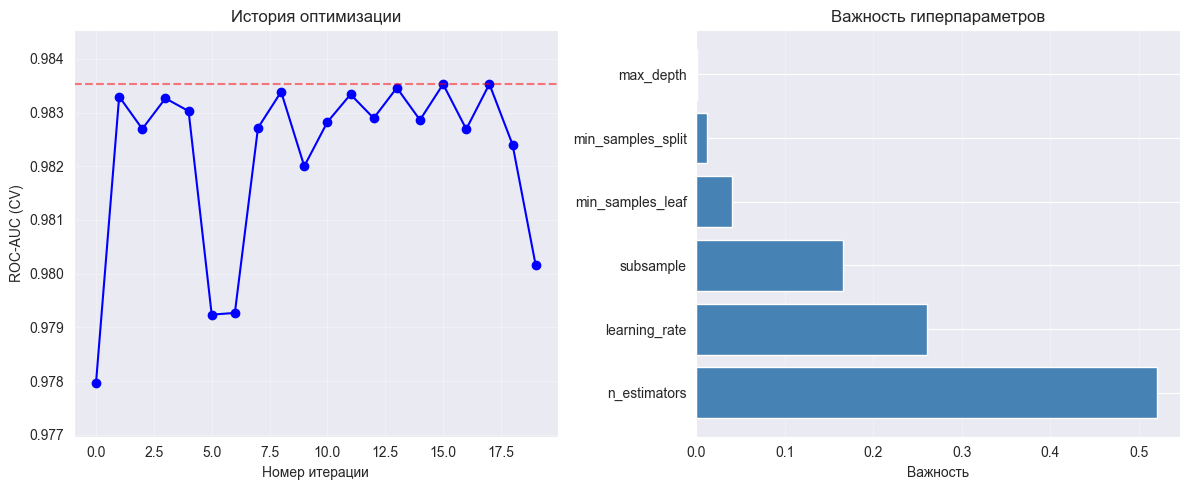

In [48]:
print("\n" + "=" * 50)
print("ПОДБОР ГИПЕРПАРАМЕТРОВ С OPTUNA")
print("=" * 50)

def objective(trial):

    if BEST_CLASSIFIER == GradientBoostingClassifier:
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 300),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
            'max_depth': trial.suggest_int('max_depth', 3, 8),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'random_state': 42
        }
        model = GradientBoostingClassifier(**params)


    else:
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 300),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
            'max_depth': trial.suggest_int('max_depth', 3, 8),
            'random_state': 42
        }
        model = BEST_CLASSIFIER(**params)

    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_processed, y, cv=cv,
                           scoring='roc_auc', n_jobs=-1)

    return scores.mean()

print(f"Запуск оптимизации Optuna для {best_algorithm}...")
print(f"Количество итераций: 20")

study = optuna.create_study(
    direction='maximize',
    study_name=f'optimization_{best_algorithm.replace(" ", "_")}'
)

study.optimize(objective, n_trials=20, show_progress_bar=True)

print("\n" + "=" * 50)
print("РЕЗУЛЬТАТЫ ОПТИМИЗАЦИИ:")
print("=" * 50)
print(f"Лучшее значение ROC-AUC: {study.best_value:.6f}")
print(f"Лучшие параметры: {study.best_params}")
print(f"Количество итераций: {len(study.trials)}")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

history_df = study.trials_dataframe()
axes[0].plot(history_df['number'], history_df['value'], 'b-', marker='o')
axes[0].axhline(y=study.best_value, color='r', linestyle='--', alpha=0.5)
axes[0].set_xlabel('Номер итерации')
axes[0].set_ylabel('ROC-AUC (CV)')
axes[0].set_title('История оптимизации')
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim([history_df['value'].min() - 0.001, history_df['value'].max() + 0.001])

try:
    param_importance = optuna.importance.get_param_importances(study)
    if param_importance:
        params = list(param_importance.keys())
        importance = list(param_importance.values())

        axes[1].barh(params, importance, color='steelblue')
        axes[1].set_xlabel('Важность')
        axes[1].set_title('Важность гиперпараметров')
        axes[1].grid(True, axis='x', alpha=0.3)
except:
    axes[1].text(0.5, 0.5, 'Не удалось рассчитать\nважность параметров',
                ha='center', va='center', transform=axes[1].transAxes)
    axes[1].set_title('Важность гиперпараметров')

plt.tight_layout()
plt.show()


Обучение финальной модели (XGBoost) с лучшими параметрами...
Генерация предсказаний для тестовой выборки...

Файл 'submission_lab2.csv' успешно сохранен!
Количество предсказаний: 5000
Средняя вероятность: 0.5186
Стандартное отклонение: 0.4484


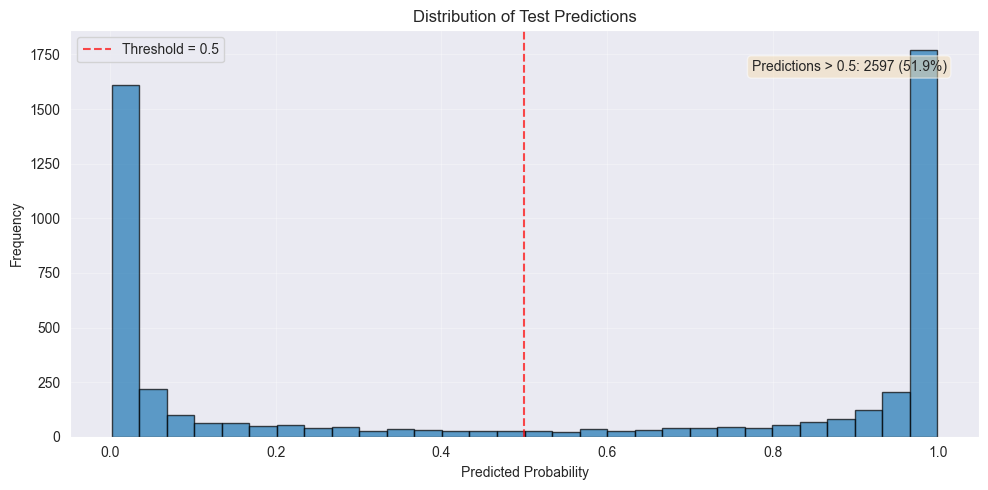

In [51]:
print(f"\nОбучение финальной модели ({best_algorithm}) с лучшими параметрами...")

best_params = study.best_params
best_params['random_state'] = 42

if BEST_CLASSIFIER == GradientBoostingClassifier:
    supported_params = {}
    for param, value in best_params.items():
        if hasattr(GradientBoostingClassifier(), param):
            supported_params[param] = value
    final_model = GradientBoostingClassifier(**supported_params)
else:
    final_model = BEST_CLASSIFIER(**best_params)

final_model.fit(X_processed, y)

print("Генерация предсказаний для тестовой выборки...")
test_predictions = final_model.predict_proba(X_test_processed)[:, 1]

submission_df = pd.DataFrame({
    'ID': test_df['ID'],
    'LoanApproved': test_predictions
})

output_file = 'submission_lab2.csv'
submission_df.to_csv(output_file, index=False)

print(f"\nФайл '{output_file}' успешно сохранен!")
print(f"Количество предсказаний: {len(test_predictions)}")
print(f"Средняя вероятность: {test_predictions.mean():.4f}")
print(f"Стандартное отклонение: {test_predictions.std():.4f}")

plt.figure(figsize=(10, 5))
plt.hist(test_predictions, bins=30, edgecolor='black', alpha=0.7)
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.title('Distribution of Test Predictions')
plt.grid(True, alpha=0.3)

plt.axvline(x=0.5, color='red', linestyle='--', alpha=0.7, label='Threshold = 0.5')

above_threshold = np.sum(test_predictions > 0.5)
percentage_above = above_threshold / len(test_predictions) * 100
plt.text(0.75, 0.9, f'Predictions > 0.5: {above_threshold} ({percentage_above:.1f}%)',
         transform=plt.gca().transAxes, fontsize=10,
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.legend()
plt.tight_layout()
plt.show()